# **Transformer Interpretability Beyond Attention Visualization**

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.


In [ ]:
!zip -r /content/files_final.zip /content/Transformer-Explainability


  adding: content/Transformer-Explainability/ (stored 0%)
  adding: content/Transformer-Explainability/standalone2/ (stored 0%)
  adding: content/Transformer-Explainability/standalone2/Saliency.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone2/LRP.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone2/CAM.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone2/Rollout.png (deflated 0%)
  adding: content/Transformer-Explainability/DeiT.PNG (deflated 0%)
  adding: content/Transformer-Explainability/standalone7/ (stored 0%)
  adding: content/Transformer-Explainability/standalone7/Saliency.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone7/LRP.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone7/CAM.png (deflated 0%)
  adding: content/Transformer-Explainability/standalone7/Rollout.png (deflated 0%)
  adding: content/Transformer-Explainability/2WAY9/ (stored 0%)
  adding: content/Tr

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [ ]:
#@title Imagenet class indices to names
%%capture
CLS2IDX = {0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma maculatum',
 29: 'axolotl, mud puppy, Ambystoma mexicanum',
 30: 'bullfrog, Rana catesbeiana',
 31: 'tree frog, tree-frog',
 32: 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 33: 'loggerhead, loggerhead turtle, Caretta caretta',
 34: 'leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle, box tortoise',
 38: 'banded gecko',
 39: 'common iguana, iguana, Iguana iguana',
 40: 'American chameleon, anole, Anolis carolinensis',
 41: 'whiptail, whiptail lizard',
 42: 'agama',
 43: 'frilled lizard, Chlamydosaurus kingi',
 44: 'alligator lizard',
 45: 'Gila monster, Heloderma suspectum',
 46: 'green lizard, Lacerta viridis',
 47: 'African chameleon, Chamaeleo chamaeleon',
 48: 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 49: 'African crocodile, Nile crocodile, Crocodylus niloticus',
 50: 'American alligator, Alligator mississipiensis',
 51: 'triceratops',
 52: 'thunder snake, worm snake, Carphophis amoenus',
 53: 'ringneck snake, ring-necked snake, ring snake',
 54: 'hognose snake, puff adder, sand viper',
 55: 'green snake, grass snake',
 56: 'king snake, kingsnake',
 57: 'garter snake, grass snake',
 58: 'water snake',
 59: 'vine snake',
 60: 'night snake, Hypsiglena torquata',
 61: 'boa constrictor, Constrictor constrictor',
 62: 'rock python, rock snake, Python sebae',
 63: 'Indian cobra, Naja naja',
 64: 'green mamba',
 65: 'sea snake',
 66: 'horned viper, cerastes, sand viper, horned asp, Cerastes cornutus',
 67: 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 68: 'sidewinder, horned rattlesnake, Crotalus cerastes',
 69: 'trilobite',
 70: 'harvestman, daddy longlegs, Phalangium opilio',
 71: 'scorpion',
 72: 'black and gold garden spider, Argiope aurantia',
 73: 'barn spider, Araneus cavaticus',
 74: 'garden spider, Aranea diademata',
 75: 'black widow, Latrodectus mactans',
 76: 'tarantula',
 77: 'wolf spider, hunting spider',
 78: 'tick',
 79: 'centipede',
 80: 'black grouse',
 81: 'ptarmigan',
 82: 'ruffed grouse, partridge, Bonasa umbellus',
 83: 'prairie chicken, prairie grouse, prairie fowl',
 84: 'peacock',
 85: 'quail',
 86: 'partridge',
 87: 'African grey, African gray, Psittacus erithacus',
 88: 'macaw',
 89: 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 90: 'lorikeet',
 91: 'coucal',
 92: 'bee eater',
 93: 'hornbill',
 94: 'hummingbird',
 95: 'jacamar',
 96: 'toucan',
 97: 'drake',
 98: 'red-breasted merganser, Mergus serrator',
 99: 'goose',
 100: 'black swan, Cygnus atratus',
 101: 'tusker',
 102: 'echidna, spiny anteater, anteater',
 103: 'platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus',
 104: 'wallaby, brush kangaroo',
 105: 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 106: 'wombat',
 107: 'jellyfish',
 108: 'sea anemone, anemone',
 109: 'brain coral',
 110: 'flatworm, platyhelminth',
 111: 'nematode, nematode worm, roundworm',
 112: 'conch',
 113: 'snail',
 114: 'slug',
 115: 'sea slug, nudibranch',
 116: 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 117: 'chambered nautilus, pearly nautilus, nautilus',
 118: 'Dungeness crab, Cancer magister',
 119: 'rock crab, Cancer irroratus',
 120: 'fiddler crab',
 121: 'king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica',
 122: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 123: 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 124: 'crayfish, crawfish, crawdad, crawdaddy',
 125: 'hermit crab',
 126: 'isopod',
 127: 'white stork, Ciconia ciconia',
 128: 'black stork, Ciconia nigra',
 129: 'spoonbill',
 130: 'flamingo',
 131: 'little blue heron, Egretta caerulea',
 132: 'American egret, great white heron, Egretta albus',
 133: 'bittern',
 134: 'crane',
 135: 'limpkin, Aramus pictus',
 136: 'European gallinule, Porphyrio porphyrio',
 137: 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 138: 'bustard',
 139: 'ruddy turnstone, Arenaria interpres',
 140: 'red-backed sandpiper, dunlin, Erolia alpina',
 141: 'redshank, Tringa totanus',
 142: 'dowitcher',
 143: 'oystercatcher, oyster catcher',
 144: 'pelican',
 145: 'king penguin, Aptenodytes patagonica',
 146: 'albatross, mollymawk',
 147: 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus',
 148: 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca',
 149: 'dugong, Dugong dugon',
 150: 'sea lion',
 151: 'Chihuahua',
 152: 'Japanese spaniel',
 153: 'Maltese dog, Maltese terrier, Maltese',
 154: 'Pekinese, Pekingese, Peke',
 155: 'Shih-Tzu',
 156: 'Blenheim spaniel',
 157: 'papillon',
 158: 'toy terrier',
 159: 'Rhodesian ridgeback',
 160: 'Afghan hound, Afghan',
 161: 'basset, basset hound',
 162: 'beagle',
 163: 'bloodhound, sleuthhound',
 164: 'bluetick',
 165: 'black-and-tan coonhound',
 166: 'Walker hound, Walker foxhound',
 167: 'English foxhound',
 168: 'redbone',
 169: 'borzoi, Russian wolfhound',
 170: 'Irish wolfhound',
 171: 'Italian greyhound',
 172: 'whippet',
 173: 'Ibizan hound, Ibizan Podenco',
 174: 'Norwegian elkhound, elkhound',
 175: 'otterhound, otter hound',
 176: 'Saluki, gazelle hound',
 177: 'Scottish deerhound, deerhound',
 178: 'Weimaraner',
 179: 'Staffordshire bullterrier, Staffordshire bull terrier',
 180: 'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
 181: 'Bedlington terrier',
 182: 'Border terrier',
 183: 'Kerry blue terrier',
 184: 'Irish terrier',
 185: 'Norfolk terrier',
 186: 'Norwich terrier',
 187: 'Yorkshire terrier',
 188: 'wire-haired fox terrier',
 189: 'Lakeland terrier',
 190: 'Sealyham terrier, Sealyham',
 191: 'Airedale, Airedale terrier',
 192: 'cairn, cairn terrier',
 193: 'Australian terrier',
 194: 'Dandie Dinmont, Dandie Dinmont terrier',
 195: 'Boston bull, Boston terrier',
 196: 'miniature schnauzer',
 197: 'giant schnauzer',
 198: 'standard schnauzer',
 199: 'Scotch terrier, Scottish terrier, Scottie',
 200: 'Tibetan terrier, chrysanthemum dog',
 201: 'silky terrier, Sydney silky',
 202: 'soft-coated wheaten terrier',
 203: 'West Highland white terrier',
 204: 'Lhasa, Lhasa apso',
 205: 'flat-coated retriever',
 206: 'curly-coated retriever',
 207: 'golden retriever',
 208: 'Labrador retriever',
 209: 'Chesapeake Bay retriever',
 210: 'German short-haired pointer',
 211: 'vizsla, Hungarian pointer',
 212: 'English setter',
 213: 'Irish setter, red setter',
 214: 'Gordon setter',
 215: 'Brittany spaniel',
 216: 'clumber, clumber spaniel',
 217: 'English springer, English springer spaniel',
 218: 'Welsh springer spaniel',
 219: 'cocker spaniel, English cocker spaniel, cocker',
 220: 'Sussex spaniel',
 221: 'Irish water spaniel',
 222: 'kuvasz',
 223: 'schipperke',
 224: 'groenendael',
 225: 'malinois',
 226: 'briard',
 227: 'kelpie',
 228: 'komondor',
 229: 'Old English sheepdog, bobtail',
 230: 'Shetland sheepdog, Shetland sheep dog, Shetland',
 231: 'collie',
 232: 'Border collie',
 233: 'Bouvier des Flandres, Bouviers des Flandres',
 234: 'Rottweiler',
 235: 'German shepherd, German shepherd dog, German police dog, alsatian',
 236: 'Doberman, Doberman pinscher',
 237: 'miniature pinscher',
 238: 'Greater Swiss Mountain dog',
 239: 'Bernese mountain dog',
 240: 'Appenzeller',
 241: 'EntleBucher',
 242: 'boxer',
 243: 'bull mastiff',
 244: 'Tibetan mastiff',
 245: 'French bulldog',
 246: 'Great Dane',
 247: 'Saint Bernard, St Bernard',
 248: 'Eskimo dog, husky',
 249: 'malamute, malemute, Alaskan malamute',
 250: 'Siberian husky',
 251: 'dalmatian, coach dog, carriage dog',
 252: 'affenpinscher, monkey pinscher, monkey dog',
 253: 'basenji',
 254: 'pug, pug-dog',
 255: 'Leonberg',
 256: 'Newfoundland, Newfoundland dog',
 257: 'Great Pyrenees',
 258: 'Samoyed, Samoyede',
 259: 'Pomeranian',
 260: 'chow, chow chow',
 261: 'keeshond',
 262: 'Brabancon griffon',
 263: 'Pembroke, Pembroke Welsh corgi',
 264: 'Cardigan, Cardigan Welsh corgi',
 265: 'toy poodle',
 266: 'miniature poodle',
 267: 'standard poodle',
 268: 'Mexican hairless',
 269: 'timber wolf, grey wolf, gray wolf, Canis lupus',
 270: 'white wolf, Arctic wolf, Canis lupus tundrarum',
 271: 'red wolf, maned wolf, Canis rufus, Canis niger',
 272: 'coyote, prairie wolf, brush wolf, Canis latrans',
 273: 'dingo, warrigal, warragal, Canis dingo',
 274: 'dhole, Cuon alpinus',
 275: 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 276: 'hyena, hyaena',
 277: 'red fox, Vulpes vulpes',
 278: 'kit fox, Vulpes macrotis',
 279: 'Arctic fox, white fox, Alopex lagopus',
 280: 'grey fox, gray fox, Urocyon cinereoargenteus',
 281: 'tabby, tabby cat',
 282: 'tiger cat',
 283: 'Persian cat',
 284: 'Siamese cat, Siamese',
 285: 'Egyptian cat',
 286: 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 287: 'lynx, catamount',
 288: 'leopard, Panthera pardus',
 289: 'snow leopard, ounce, Panthera uncia',
 290: 'jaguar, panther, Panthera onca, Felis onca',
 291: 'lion, king of beasts, Panthera leo',
 292: 'tiger, Panthera tigris',
 293: 'cheetah, chetah, Acinonyx jubatus',
 294: 'brown bear, bruin, Ursus arctos',
 295: 'American black bear, black bear, Ursus americanus, Euarctos americanus',
 296: 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
 297: 'sloth bear, Melursus ursinus, Ursus ursinus',
 298: 'mongoose',
 299: 'meerkat, mierkat',
 300: 'tiger beetle',
 301: 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 302: 'ground beetle, carabid beetle',
 303: 'long-horned beetle, longicorn, longicorn beetle',
 304: 'leaf beetle, chrysomelid',
 305: 'dung beetle',
 306: 'rhinoceros beetle',
 307: 'weevil',
 308: 'fly',
 309: 'bee',
 310: 'ant, emmet, pismire',
 311: 'grasshopper, hopper',
 312: 'cricket',
 313: 'walking stick, walkingstick, stick insect',
 314: 'cockroach, roach',
 315: 'mantis, mantid',
 316: 'cicada, cicala',
 317: 'leafhopper',
 318: 'lacewing, lacewing fly',
 319: "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 320: 'damselfly',
 321: 'admiral',
 322: 'ringlet, ringlet butterfly',
 323: 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus',
 324: 'cabbage butterfly',
 325: 'sulphur butterfly, sulfur butterfly',
 326: 'lycaenid, lycaenid butterfly',
 327: 'starfish, sea star',
 328: 'sea urchin',
 329: 'sea cucumber, holothurian',
 330: 'wood rabbit, cottontail, cottontail rabbit',
 331: 'hare',
 332: 'Angora, Angora rabbit',
 333: 'hamster',
 334: 'porcupine, hedgehog',
 335: 'fox squirrel, eastern fox squirrel, Sciurus niger',
 336: 'marmot',
 337: 'beaver',
 338: 'guinea pig, Cavia cobaya',
 339: 'sorrel',
 340: 'zebra',
 341: 'hog, pig, grunter, squealer, Sus scrofa',
 342: 'wild boar, boar, Sus scrofa',
 343: 'warthog',
 344: 'hippopotamus, hippo, river horse, Hippopotamus amphibius',
 345: 'ox',
 346: 'water buffalo, water ox, Asiatic buffalo, Bubalus bubalis',
 347: 'bison',
 348: 'ram, tup',
 349: 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis',
 350: 'ibex, Capra ibex',
 351: 'hartebeest',
 352: 'impala, Aepyceros melampus',
 353: 'gazelle',
 354: 'Arabian camel, dromedary, Camelus dromedarius',
 355: 'llama',
 356: 'weasel',
 357: 'mink',
 358: 'polecat, fitch, foulmart, foumart, Mustela putorius',
 359: 'black-footed ferret, ferret, Mustela nigripes',
 360: 'otter',
 361: 'skunk, polecat, wood pussy',
 362: 'badger',
 363: 'armadillo',
 364: 'three-toed sloth, ai, Bradypus tridactylus',
 365: 'orangutan, orang, orangutang, Pongo pygmaeus',
 366: 'gorilla, Gorilla gorilla',
 367: 'chimpanzee, chimp, Pan troglodytes',
 368: 'gibbon, Hylobates lar',
 369: 'siamang, Hylobates syndactylus, Symphalangus syndactylus',
 370: 'guenon, guenon monkey',
 371: 'patas, hussar monkey, Erythrocebus patas',
 372: 'baboon',
 373: 'macaque',
 374: 'langur',
 375: 'colobus, colobus monkey',
 376: 'proboscis monkey, Nasalis larvatus',
 377: 'marmoset',
 378: 'capuchin, ringtail, Cebus capucinus',
 379: 'howler monkey, howler',
 380: 'titi, titi monkey',
 381: 'spider monkey, Ateles geoffroyi',
 382: 'squirrel monkey, Saimiri sciureus',
 383: 'Madagascar cat, ring-tailed lemur, Lemur catta',
 384: 'indri, indris, Indri indri, Indri brevicaudatus',
 385: 'Indian elephant, Elephas maximus',
 386: 'African elephant, Loxodonta africana',
 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',
 388: 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',
 389: 'barracouta, snoek',
 390: 'eel',
 391: 'coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch',
 392: 'rock beauty, Holocanthus tricolor',
 393: 'anemone fish',
 394: 'sturgeon',
 395: 'gar, garfish, garpike, billfish, Lepisosteus osseus',
 396: 'lionfish',
 397: 'puffer, pufferfish, blowfish, globefish',
 398: 'abacus',
 399: 'abaya',
 400: "academic gown, academic robe, judge's robe",
 401: 'accordion, piano accordion, squeeze box',
 402: 'acoustic guitar',
 403: 'aircraft carrier, carrier, flattop, attack aircraft carrier',
 404: 'airliner',
 405: 'airship, dirigible',
 406: 'altar',
 407: 'ambulance',
 408: 'amphibian, amphibious vehicle',
 409: 'analog clock',
 410: 'apiary, bee house',
 411: 'apron',
 412: 'ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin',
 413: 'assault rifle, assault gun',
 414: 'backpack, back pack, knapsack, packsack, rucksack, haversack',
 415: 'bakery, bakeshop, bakehouse',
 416: 'balance beam, beam',
 417: 'balloon',
 418: 'ballpoint, ballpoint pen, ballpen, Biro',
 419: 'Band Aid',
 420: 'banjo',
 421: 'bannister, banister, balustrade, balusters, handrail',
 422: 'barbell',
 423: 'barber chair',
 424: 'barbershop',
 425: 'barn',
 426: 'barometer',
 427: 'barrel, cask',
 428: 'barrow, garden cart, lawn cart, wheelbarrow',
 429: 'baseball',
 430: 'basketball',
 431: 'bassinet',
 432: 'bassoon',
 433: 'bathing cap, swimming cap',
 434: 'bath towel',
 435: 'bathtub, bathing tub, bath, tub',
 436: 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
 437: 'beacon, lighthouse, beacon light, pharos',
 438: 'beaker',
 439: 'bearskin, busby, shako',
 440: 'beer bottle',
 441: 'beer glass',
 442: 'bell cote, bell cot',
 443: 'bib',
 444: 'bicycle-built-for-two, tandem bicycle, tandem',
 445: 'bikini, two-piece',
 446: 'binder, ring-binder',
 447: 'binoculars, field glasses, opera glasses',
 448: 'birdhouse',
 449: 'boathouse',
 450: 'bobsled, bobsleigh, bob',
 451: 'bolo tie, bolo, bola tie, bola',
 452: 'bonnet, poke bonnet',
 453: 'bookcase',
 454: 'bookshop, bookstore, bookstall',
 455: 'bottlecap',
 456: 'bow',
 457: 'bow tie, bow-tie, bowtie',
 458: 'brass, memorial tablet, plaque',
 459: 'brassiere, bra, bandeau',
 460: 'breakwater, groin, groyne, mole, bulwark, seawall, jetty',
 461: 'breastplate, aegis, egis',
 462: 'broom',
 463: 'bucket, pail',
 464: 'buckle',
 465: 'bulletproof vest',
 466: 'bullet train, bullet',
 467: 'butcher shop, meat market',
 468: 'cab, hack, taxi, taxicab',
 469: 'caldron, cauldron',
 470: 'candle, taper, wax light',
 471: 'cannon',
 472: 'canoe',
 473: 'can opener, tin opener',
 474: 'cardigan',
 475: 'car mirror',
 476: 'carousel, carrousel, merry-go-round, roundabout, whirligig',
 477: "carpenter's kit, tool kit",
 478: 'carton',
 479: 'car wheel',
 480: 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
 481: 'cassette',
 482: 'cassette player',
 483: 'castle',
 484: 'catamaran',
 485: 'CD player',
 486: 'cello, violoncello',
 487: 'cellular telephone, cellular phone, cellphone, cell, mobile phone',
 488: 'chain',
 489: 'chainlink fence',
 490: 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 491: 'chain saw, chainsaw',
 492: 'chest',
 493: 'chiffonier, commode',
 494: 'chime, bell, gong',
 495: 'china cabinet, china closet',
 496: 'Christmas stocking',
 497: 'church, church building',
 498: 'cinema, movie theater, movie theatre, movie house, picture palace',
 499: 'cleaver, meat cleaver, chopper',
 500: 'cliff dwelling',
 501: 'cloak',
 502: 'clog, geta, patten, sabot',
 503: 'cocktail shaker',
 504: 'coffee mug',
 505: 'coffeepot',
 506: 'coil, spiral, volute, whorl, helix',
 507: 'combination lock',
 508: 'computer keyboard, keypad',
 509: 'confectionery, confectionary, candy store',
 510: 'container ship, containership, container vessel',
 511: 'convertible',
 512: 'corkscrew, bottle screw',
 513: 'cornet, horn, trumpet, trump',
 514: 'cowboy boot',
 515: 'cowboy hat, ten-gallon hat',
 516: 'cradle',
 517: 'crane',
 518: 'crash helmet',
 519: 'crate',
 520: 'crib, cot',
 521: 'Crock Pot',
 522: 'croquet ball',
 523: 'crutch',
 524: 'cuirass',
 525: 'dam, dike, dyke',
 526: 'desk',
 527: 'desktop computer',
 528: 'dial telephone, dial phone',
 529: 'diaper, nappy, napkin',
 530: 'digital clock',
 531: 'digital watch',
 532: 'dining table, board',
 533: 'dishrag, dishcloth',
 534: 'dishwasher, dish washer, dishwashing machine',
 535: 'disk brake, disc brake',
 536: 'dock, dockage, docking facility',
 537: 'dogsled, dog sled, dog sleigh',
 538: 'dome',
 539: 'doormat, welcome mat',
 540: 'drilling platform, offshore rig',
 541: 'drum, membranophone, tympan',
 542: 'drumstick',
 543: 'dumbbell',
 544: 'Dutch oven',
 545: 'electric fan, blower',
 546: 'electric guitar',
 547: 'electric locomotive',
 548: 'entertainment center',
 549: 'envelope',
 550: 'espresso maker',
 551: 'face powder',
 552: 'feather boa, boa',
 553: 'file, file cabinet, filing cabinet',
 554: 'fireboat',
 555: 'fire engine, fire truck',
 556: 'fire screen, fireguard',
 557: 'flagpole, flagstaff',
 558: 'flute, transverse flute',
 559: 'folding chair',
 560: 'football helmet',
 561: 'forklift',
 562: 'fountain',
 563: 'fountain pen',
 564: 'four-poster',
 565: 'freight car',
 566: 'French horn, horn',
 567: 'frying pan, frypan, skillet',
 568: 'fur coat',
 569: 'garbage truck, dustcart',
 570: 'gasmask, respirator, gas helmet',
 571: 'gas pump, gasoline pump, petrol pump, island dispenser',
 572: 'goblet',
 573: 'go-kart',
 574: 'golf ball',
 575: 'golfcart, golf cart',
 576: 'gondola',
 577: 'gong, tam-tam',
 578: 'gown',
 579: 'grand piano, grand',
 580: 'greenhouse, nursery, glasshouse',
 581: 'grille, radiator grille',
 582: 'grocery store, grocery, food market, market',
 583: 'guillotine',
 584: 'hair slide',
 585: 'hair spray',
 586: 'half track',
 587: 'hammer',
 588: 'hamper',
 589: 'hand blower, blow dryer, blow drier, hair dryer, hair drier',
 590: 'hand-held computer, hand-held microcomputer',
 591: 'handkerchief, hankie, hanky, hankey',
 592: 'hard disc, hard disk, fixed disk',
 593: 'harmonica, mouth organ, harp, mouth harp',
 594: 'harp',
 595: 'harvester, reaper',
 596: 'hatchet',
 597: 'holster',
 598: 'home theater, home theatre',
 599: 'honeycomb',
 600: 'hook, claw',
 601: 'hoopskirt, crinoline',
 602: 'horizontal bar, high bar',
 603: 'horse cart, horse-cart',
 604: 'hourglass',
 605: 'iPod',
 606: 'iron, smoothing iron',
 607: "jack-o'-lantern",
 608: 'jean, blue jean, denim',
 609: 'jeep, landrover',
 610: 'jersey, T-shirt, tee shirt',
 611: 'jigsaw puzzle',
 612: 'jinrikisha, ricksha, rickshaw',
 613: 'joystick',
 614: 'kimono',
 615: 'knee pad',
 616: 'knot',
 617: 'lab coat, laboratory coat',
 618: 'ladle',
 619: 'lampshade, lamp shade',
 620: 'laptop, laptop computer',
 621: 'lawn mower, mower',
 622: 'lens cap, lens cover',
 623: 'letter opener, paper knife, paperknife',
 624: 'library',
 625: 'lifeboat',
 626: 'lighter, light, igniter, ignitor',
 627: 'limousine, limo',
 628: 'liner, ocean liner',
 629: 'lipstick, lip rouge',
 630: 'Loafer',
 631: 'lotion',
 632: 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 633: "loupe, jeweler's loupe",
 634: 'lumbermill, sawmill',
 635: 'magnetic compass',
 636: 'mailbag, postbag',
 637: 'mailbox, letter box',
 638: 'maillot',
 639: 'maillot, tank suit',
 640: 'manhole cover',
 641: 'maraca',
 642: 'marimba, xylophone',
 643: 'mask',
 644: 'matchstick',
 645: 'maypole',
 646: 'maze, labyrinth',
 647: 'measuring cup',
 648: 'medicine chest, medicine cabinet',
 649: 'megalith, megalithic structure',
 650: 'microphone, mike',
 651: 'microwave, microwave oven',
 652: 'military uniform',
 653: 'milk can',
 654: 'minibus',
 655: 'miniskirt, mini',
 656: 'minivan',
 657: 'missile',
 658: 'mitten',
 659: 'mixing bowl',
 660: 'mobile home, manufactured home',
 661: 'Model T',
 662: 'modem',
 663: 'monastery',
 664: 'monitor',
 665: 'moped',
 666: 'mortar',
 667: 'mortarboard',
 668: 'mosque',
 669: 'mosquito net',
 670: 'motor scooter, scooter',
 671: 'mountain bike, all-terrain bike, off-roader',
 672: 'mountain tent',
 673: 'mouse, computer mouse',
 674: 'mousetrap',
 675: 'moving van',
 676: 'muzzle',
 677: 'nail',
 678: 'neck brace',
 679: 'necklace',
 680: 'nipple',
 681: 'notebook, notebook computer',
 682: 'obelisk',
 683: 'oboe, hautboy, hautbois',
 684: 'ocarina, sweet potato',
 685: 'odometer, hodometer, mileometer, milometer',
 686: 'oil filter',
 687: 'organ, pipe organ',
 688: 'oscilloscope, scope, cathode-ray oscilloscope, CRO',
 689: 'overskirt',
 690: 'oxcart',
 691: 'oxygen mask',
 692: 'packet',
 693: 'paddle, boat paddle',
 694: 'paddlewheel, paddle wheel',
 695: 'padlock',
 696: 'paintbrush',
 697: "pajama, pyjama, pj's, jammies",
 698: 'palace',
 699: 'panpipe, pandean pipe, syrinx',
 700: 'paper towel',
 701: 'parachute, chute',
 702: 'parallel bars, bars',
 703: 'park bench',
 704: 'parking meter',
 705: 'passenger car, coach, carriage',
 706: 'patio, terrace',
 707: 'pay-phone, pay-station',
 708: 'pedestal, plinth, footstall',
 709: 'pencil box, pencil case',
 710: 'pencil sharpener',
 711: 'perfume, essence',
 712: 'Petri dish',
 713: 'photocopier',
 714: 'pick, plectrum, plectron',
 715: 'pickelhaube',
 716: 'picket fence, paling',
 717: 'pickup, pickup truck',
 718: 'pier',
 719: 'piggy bank, penny bank',
 720: 'pill bottle',
 721: 'pillow',
 722: 'ping-pong ball',
 723: 'pinwheel',
 724: 'pirate, pirate ship',
 725: 'pitcher, ewer',
 726: "plane, carpenter's plane, woodworking plane",
 727: 'planetarium',
 728: 'plastic bag',
 729: 'plate rack',
 730: 'plow, plough',
 731: "plunger, plumber's helper",
 732: 'Polaroid camera, Polaroid Land camera',
 733: 'pole',
 734: 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria',
 735: 'poncho',
 736: 'pool table, billiard table, snooker table',
 737: 'pop bottle, soda bottle',
 738: 'pot, flowerpot',
 739: "potter's wheel",
 740: 'power drill',
 741: 'prayer rug, prayer mat',
 742: 'printer',
 743: 'prison, prison house',
 744: 'projectile, missile',
 745: 'projector',
 746: 'puck, hockey puck',
 747: 'punching bag, punch bag, punching ball, punchball',
 748: 'purse',
 749: 'quill, quill pen',
 750: 'quilt, comforter, comfort, puff',
 751: 'racer, race car, racing car',
 752: 'racket, racquet',
 753: 'radiator',
 754: 'radio, wireless',
 755: 'radio telescope, radio reflector',
 756: 'rain barrel',
 757: 'recreational vehicle, RV, R.V.',
 758: 'reel',
 759: 'reflex camera',
 760: 'refrigerator, icebox',
 761: 'remote control, remote',
 762: 'restaurant, eating house, eating place, eatery',
 763: 'revolver, six-gun, six-shooter',
 764: 'rifle',
 765: 'rocking chair, rocker',
 766: 'rotisserie',
 767: 'rubber eraser, rubber, pencil eraser',
 768: 'rugby ball',
 769: 'rule, ruler',
 770: 'running shoe',
 771: 'safe',
 772: 'safety pin',
 773: 'saltshaker, salt shaker',
 774: 'sandal',
 775: 'sarong',
 776: 'sax, saxophone',
 777: 'scabbard',
 778: 'scale, weighing machine',
 779: 'school bus',
 780: 'schooner',
 781: 'scoreboard',
 782: 'screen, CRT screen',
 783: 'screw',
 784: 'screwdriver',
 785: 'seat belt, seatbelt',
 786: 'sewing machine',
 787: 'shield, buckler',
 788: 'shoe shop, shoe-shop, shoe store',
 789: 'shoji',
 790: 'shopping basket',
 791: 'shopping cart',
 792: 'shovel',
 793: 'shower cap',
 794: 'shower curtain',
 795: 'ski',
 796: 'ski mask',
 797: 'sleeping bag',
 798: 'slide rule, slipstick',
 799: 'sliding door',
 800: 'slot, one-armed bandit',
 801: 'snorkel',
 802: 'snowmobile',
 803: 'snowplow, snowplough',
 804: 'soap dispenser',
 805: 'soccer ball',
 806: 'sock',
 807: 'solar dish, solar collector, solar furnace',
 808: 'sombrero',
 809: 'soup bowl',
 810: 'space bar',
 811: 'space heater',
 812: 'space shuttle',
 813: 'spatula',
 814: 'speedboat',
 815: "spider web, spider's web",
 816: 'spindle',
 817: 'sports car, sport car',
 818: 'spotlight, spot',
 819: 'stage',
 820: 'steam locomotive',
 821: 'steel arch bridge',
 822: 'steel drum',
 823: 'stethoscope',
 824: 'stole',
 825: 'stone wall',
 826: 'stopwatch, stop watch',
 827: 'stove',
 828: 'strainer',
 829: 'streetcar, tram, tramcar, trolley, trolley car',
 830: 'stretcher',
 831: 'studio couch, day bed',
 832: 'stupa, tope',
 833: 'submarine, pigboat, sub, U-boat',
 834: 'suit, suit of clothes',
 835: 'sundial',
 836: 'sunglass',
 837: 'sunglasses, dark glasses, shades',
 838: 'sunscreen, sunblock, sun blocker',
 839: 'suspension bridge',
 840: 'swab, swob, mop',
 841: 'sweatshirt',
 842: 'swimming trunks, bathing trunks',
 843: 'swing',
 844: 'switch, electric switch, electrical switch',
 845: 'syringe',
 846: 'table lamp',
 847: 'tank, army tank, armored combat vehicle, armoured combat vehicle',
 848: 'tape player',
 849: 'teapot',
 850: 'teddy, teddy bear',
 851: 'television, television system',
 852: 'tennis ball',
 853: 'thatch, thatched roof',
 854: 'theater curtain, theatre curtain',
 855: 'thimble',
 856: 'thresher, thrasher, threshing machine',
 857: 'throne',
 858: 'tile roof',
 859: 'toaster',
 860: 'tobacco shop, tobacconist shop, tobacconist',
 861: 'toilet seat',
 862: 'torch',
 863: 'totem pole',
 864: 'tow truck, tow car, wrecker',
 865: 'toyshop',
 866: 'tractor',
 867: 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi',
 868: 'tray',
 869: 'trench coat',
 870: 'tricycle, trike, velocipede',
 871: 'trimaran',
 872: 'tripod',
 873: 'triumphal arch',
 874: 'trolleybus, trolley coach, trackless trolley',
 875: 'trombone',
 876: 'tub, vat',
 877: 'turnstile',
 878: 'typewriter keyboard',
 879: 'umbrella',
 880: 'unicycle, monocycle',
 881: 'upright, upright piano',
 882: 'vacuum, vacuum cleaner',
 883: 'vase',
 884: 'vault',
 885: 'velvet',
 886: 'vending machine',
 887: 'vestment',
 888: 'viaduct',
 889: 'violin, fiddle',
 890: 'volleyball',
 891: 'waffle iron',
 892: 'wall clock',
 893: 'wallet, billfold, notecase, pocketbook',
 894: 'wardrobe, closet, press',
 895: 'warplane, military plane',
 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin',
 897: 'washer, automatic washer, washing machine',
 898: 'water bottle',
 899: 'water jug',
 900: 'water tower',
 901: 'whiskey jug',
 902: 'whistle',
 903: 'wig',
 904: 'window screen',
 905: 'window shade',
 906: 'Windsor tie',
 907: 'wine bottle',
 908: 'wing',
 909: 'wok',
 910: 'wooden spoon',
 911: 'wool, woolen, woollen',
 912: 'worm fence, snake fence, snake-rail fence, Virginia fence',
 913: 'wreck',
 914: 'yawl',
 915: 'yurt',
 916: 'web site, website, internet site, site',
 917: 'comic book',
 918: 'crossword puzzle, crossword',
 919: 'street sign',
 920: 'traffic light, traffic signal, stoplight',
 921: 'book jacket, dust cover, dust jacket, dust wrapper',
 922: 'menu',
 923: 'plate',
 924: 'guacamole',
 925: 'consomme',
 926: 'hot pot, hotpot',
 927: 'trifle',
 928: 'ice cream, icecream',
 929: 'ice lolly, lolly, lollipop, popsicle',
 930: 'French loaf',
 931: 'bagel, beigel',
 932: 'pretzel',
 933: 'cheeseburger',
 934: 'hotdog, hot dog, red hot',
 935: 'mashed potato',
 936: 'head cabbage',
 937: 'broccoli',
 938: 'cauliflower',
 939: 'zucchini, courgette',
 940: 'spaghetti squash',
 941: 'acorn squash',
 942: 'butternut squash',
 943: 'cucumber, cuke',
 944: 'artichoke, globe artichoke',
 945: 'bell pepper',
 946: 'cardoon',
 947: 'mushroom',
 948: 'Granny Smith',
 949: 'strawberry',
 950: 'orange',
 951: 'lemon',
 952: 'fig',
 953: 'pineapple, ananas',
 954: 'banana',
 955: 'jackfruit, jak, jack',
 956: 'custard apple',
 957: 'pomegranate',
 958: 'hay',
 959: 'carbonara',
 960: 'chocolate sauce, chocolate syrup',
 961: 'dough',
 962: 'meat loaf, meatloaf',
 963: 'pizza, pizza pie',
 964: 'potpie',
 965: 'burrito',
 966: 'red wine',
 967: 'espresso',
 968: 'cup',
 969: 'eggnog',
 970: 'alp',
 971: 'bubble',
 972: 'cliff, drop, drop-off',
 973: 'coral reef',
 974: 'geyser',
 975: 'lakeside, lakeshore',
 976: 'promontory, headland, head, foreland',
 977: 'sandbar, sand bar',
 978: 'seashore, coast, seacoast, sea-coast',
 979: 'valley, vale',
 980: 'volcano',
 981: 'ballplayer, baseball player',
 982: 'groom, bridegroom',
 983: 'scuba diver',
 984: 'rapeseed',
 985: 'daisy',
 986: "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum",
 987: 'corn',
 988: 'acorn',
 989: 'hip, rose hip, rosehip',
 990: 'buckeye, horse chestnut, conker',
 991: 'coral fungus',
 992: 'agaric',
 993: 'gyromitra',
 994: 'stinkhorn, carrion fungus',
 995: 'earthstar',
 996: 'hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa',
 997: 'bolete',
 998: 'ear, spike, capitulum',
 999: 'toilet tissue, toilet paper, bathroom tissue'}

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  True#@param {type:"boolean"}

# **ViT examples**

In [ ]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None, method = "transformer_attribution"):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Top 5 classes:
	340 : zebra                               		value = 12.551	 prob = 76.4%
	386 : African elephant, Loxodonta africana		value = 10.694	 prob = 11.9%
	101 : tusker                              		value = 10.445	 prob = 9.3%
	385 : Indian elephant, Elephas maximus    		value = 8.720	 prob = 1.7%
	343 : warthog                             		value = 5.470	 prob = 0.1%


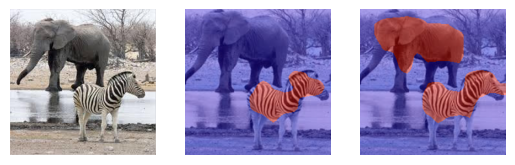

In [ ]:
## last_layer, last_layer_attn, transformer_attribution, full_lrp
from samples.CLS2IDX import CLS2IDX

num = str("el2")
folder1 = str("standalone" + num)
folder2 = str("2WAY" + num)
folder3 = str("3WAY" + num)

image = Image.open('samples/' + str(num) + ".png")
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
cat = generate_visualization(dog_cat_image)

# dog
# generate visualization for class 243: 'bull mastiff'
dog = generate_visualization(dog_cat_image, class_index=243)


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

### New -----

In [ ]:
"""# Load the model"""

from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

from baselines.ViT.ViT_explanation_generator import Baselines
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP

model1 = vit_LRP(pretrained=True).cuda()
model1.eval()
b = Baselines(model1)

# image = Image.open('/content/Transformer-Explainability/samples/catdog.png')
dog_cat_image = transform(image)

output = model(dog_cat_image.unsqueeze(0).cuda())

"""# LRP"""
def generate_visualization_LRP(original_image, class_index=None, use_thresholding=False):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def generate_saliency_visualization(original_image, class_index=None, use_thresholding=False):
    original_image.requires_grad_()  # Enable gradient tracking for the input image

    # Forward pass through the model
    output = model(original_image.unsqueeze(0).cuda())

    # Select the class for which to compute saliency
    if class_index is not None:
        loss = output[0, class_index]
    else:
        loss = output.max()  # Use the maximum score if no class index is provided

    model.zero_grad()  # Clear previous gradients

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Compute the maximum gradient magnitude across color channels
    saliency = original_image.grad.data.abs().max(dim=0)[0]

    # Move the saliency map to the CPU and convert to a NumPy array
    saliency = saliency.cpu().numpy()

    # Normalize the saliency map to the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Apply thresholding if specified
    if use_thresholding:
        saliency = saliency * 255
        saliency = saliency.astype(np.uint8)
        ret, saliency = cv2.threshold(saliency, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        saliency[saliency == 255] = 1

    # Convert the input image to a NumPy array for visualization
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()

    # Normalize the input image
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    # Overlay the saliency map on the input image
    vis = show_cam_on_image(image_transformer_attribution, saliency)

    # Convert to BGR format for OpenCV
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    return vis

# Attention rollout visualization
def visualize_rollout_heatmap(input_image, start_layer=1, use_thresholding=False):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# CAM visualization
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


In [ ]:
import os
import matplotlib.pyplot as plt

# Ensure the folder exists
os.makedirs(folder1, exist_ok=True)


#image = Image.open('samples/catdog.png')
dog_cat_image = transform(image)

# Generating visualizations
lrp_vis = generate_visualization_LRP(dog_cat_image, use_thresholding=True)
saliency_vis = generate_saliency_visualization(dog_cat_image, use_thresholding=True)
rollout_vis = visualize_rollout_heatmap(dog_cat_image, start_layer=2, use_thresholding=True)
cam_vis = visualize_CAM(dog_cat_image, use_thresholding=True)

# Plotting and saving each visualization separately
visualizations = [(lrp_vis, 'LRP'), (saliency_vis, 'Saliency'), (rollout_vis, 'Rollout'), (cam_vis, 'CAM')]

for vis, title in visualizations:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(vis)
    ax.axis('off')
    # ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(folder1, f'{title}.png'))
    plt.close(fig)


Visualizing LRP + saliency
Visualizing LRP + rollout
Visualizing LRP + CAM
Visualizing saliency + rollout
Visualizing saliency + CAM
Visualizing rollout + CAM


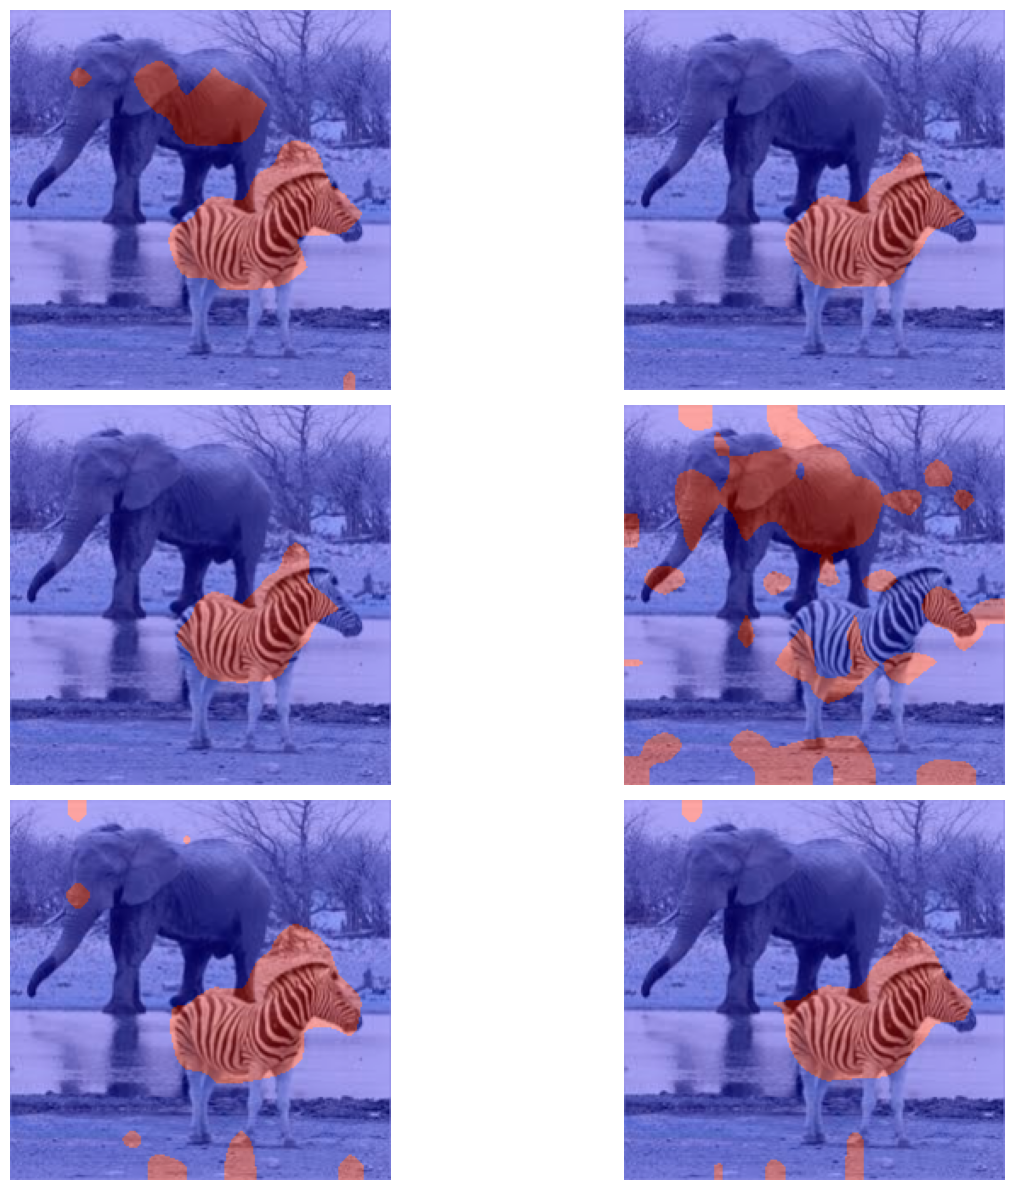

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure the folder exists
os.makedirs(folder2, exist_ok=True)

# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, method1, method2, combine_method, use_thresholding)

# Function to visualize all 2-way combinations
def visualize_all_combinations(input_image, combine_method='sqrt', use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))

    results = []
    for combo in combinations_list:
        print(f"Visualizing {' + '.join(combo)}")
        vis = visualize_combined_methods(input_image, combo[0], combo[1], combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis))

    return results

# Load image
# image = Image.open('/content/Transformer-Explainability/samples/catdog.png')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dog_cat_image = transform(image).cuda()

# Visualize all combinations
results = visualize_all_combinations(dog_cat_image, combine_method='sqrt', use_thresholding=True)

# Save the results
for name, result in results:
    save_path = os.path.join(folder2, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

# Display the results
fig, axes = plt.subplots(len(results)//2 + len(results) % 2, 2, figsize=(15, len(results)*2))
for ax, (name, result) in zip(axes.flatten(), results):
    ax.imshow(result)
    # ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()


Visualizing LRP + saliency + rollout
Visualizing LRP + saliency + CAM
Visualizing LRP + rollout + CAM
Visualizing saliency + rollout + CAM


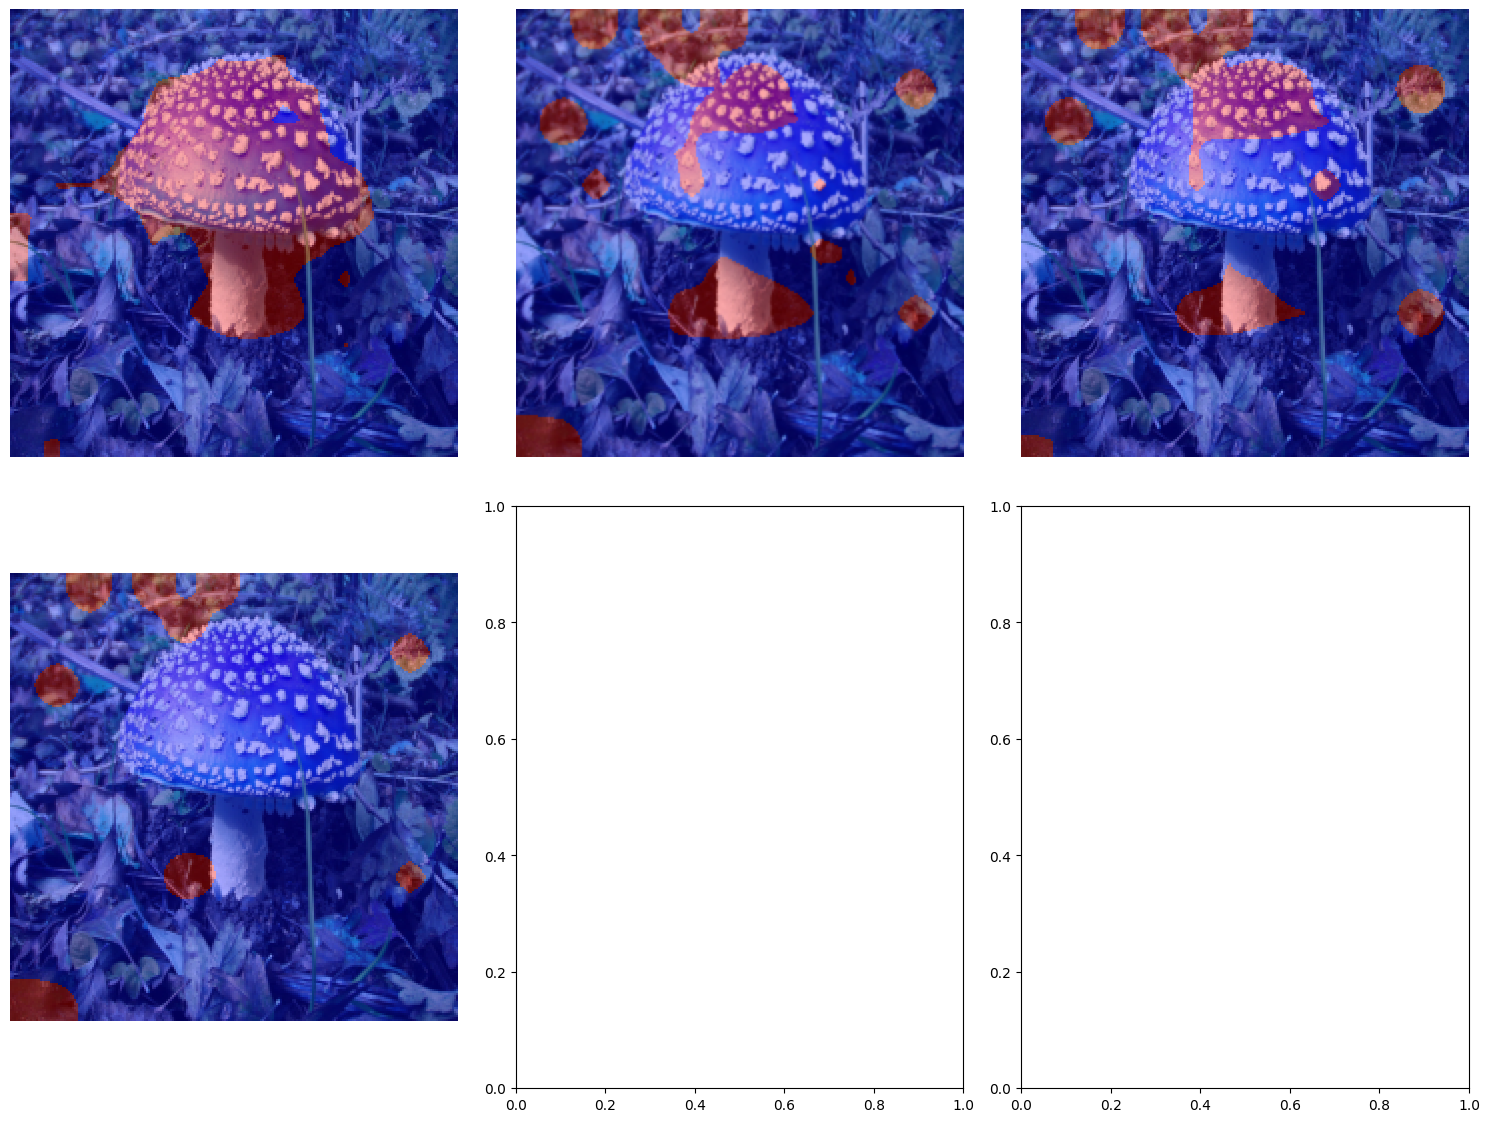

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure the folder exists
os.makedirs(folder3, exist_ok=True)

# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, methods, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attributions = []
    for method in methods:
        if method.__name__ in ['generate_saliency', 'generate_CAM']:
            attr = method(input_image, class_index=1).reshape(1, 1, 14, 14).to(device)  # class_index is set to 1 for demonstration
        else:
            attr = method(input_image).reshape(1, 1, 14, 14).to(device)
        attributions.append(attr)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attributions[0] * attributions[1] * attributions[2])
    elif combine_method == 'multiply':
        combined_attr = attributions[0] * attributions[1] * attributions[2]

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

# Example usage
def visualize_combined_methods(input_image, method_names, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    selected_methods = [methods[name] for name in method_names]

    return combine_and_visualize_attributions(input_image, selected_methods, combine_method, use_thresholding)

# Function to visualize all 3-way combinations
def visualize_all_3way_combinations(input_image, combine_method='sqrt', use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 3))

    results = []
    for combo in combinations_list:
        print(f"Visualizing {' + '.join(combo)}")
        vis = visualize_combined_methods(input_image, combo, combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis))

    return results

# Load image
# image = Image.open('/content/Transformer-Explainability/samples/catdog.png')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dog_cat_image = transform(image).cuda()

# Visualize all 3-way combinations
results = visualize_all_3way_combinations(dog_cat_image, combine_method='sqrt', use_thresholding=True)

# Save the results
for name, result in results:
    save_path = os.path.join(folder3, f"{name}.png")
    cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

# Display the results
fig, axes = plt.subplots(len(results)//3 + len(results) % 3, 3, figsize=(15, len(results)*3))
for ax, (name, result) in zip(axes.flatten(), results):
    ax.imshow(result)
    # ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 6.55 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 662.4 kB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T


def generate_visualization(original_image, class_index=None, method = "transformer_attribution"):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method=method, index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

"""# LRP"""
def generate_visualization_LRP(original_image, class_index=None, use_thresholding=False):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

def generate_saliency_visualization(original_image, class_index=None, use_thresholding=False):
    original_image.requires_grad_()  # Enable gradient tracking for the input image

    # Forward pass through the model
    output = model(original_image.unsqueeze(0).cuda())

    # Select the class for which to compute saliency
    if class_index is not None:
        loss = output[0, class_index]
    else:
        loss = output.max()  # Use the maximum score if no class index is provided

    model.zero_grad()  # Clear previous gradients

    # Backpropagate the loss to compute gradients with respect to the input image
    loss.backward()

    # Compute the maximum gradient magnitude across color channels
    saliency = original_image.grad.data.abs().max(dim=0)[0]

    # Move the saliency map to the CPU and convert to a NumPy array
    saliency = saliency.cpu().numpy()

    # Normalize the saliency map to the range [0, 1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Apply thresholding if specified
    if use_thresholding:
        saliency = saliency * 255
        saliency = saliency.astype(np.uint8)
        ret, saliency = cv2.threshold(saliency, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        saliency[saliency == 255] = 1

    # Convert the input image to a NumPy array for visualization
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()

    # Normalize the input image
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())

    # Overlay the saliency map on the input image
    vis = show_cam_on_image(image_transformer_attribution, saliency)

    # Convert to BGR format for OpenCV
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    return vis, saliency

# Attention rollout visualization
def visualize_rollout_heatmap(input_image, start_layer=2, use_thresholding=False):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

# CAM visualization
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

def overlay_mask_original(image, mask, alpha=1):
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Create a color mask
    color_mask = np.zeros_like(image)
    color_mask[..., 1] = mask * 255  # Green channel

    # Overlay the mask on the image
    overlayed_image = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return overlayed_image

def overlay_mask(image, mask, alpha=1):
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Create a white color mask
    color_mask = np.zeros_like(image)
    color_mask[mask == 1] = [255, 255, 255]  # White color mask

    # Overlay the mask on the image
    overlayed_image = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)
    return overlayed_image

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# Define transformations
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Load PASCAL VOC 2012 dataset
dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=T.ToTensor())



Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


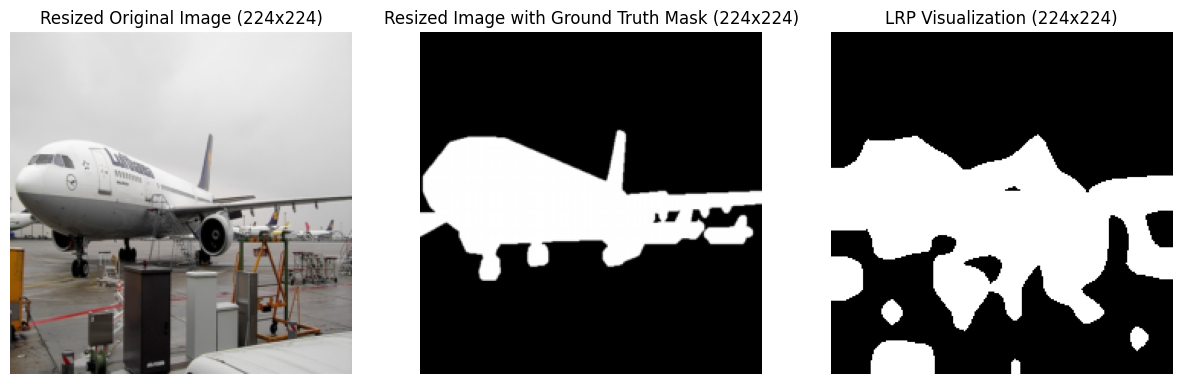

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T

# Define transformations
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

from baselines.ViT.ViT_explanation_generator import Baselines
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP

model1 = vit_LRP(pretrained=True).cuda()
model1.eval()
b = Baselines(model1)


# Load PASCAL VOC 2012 dataset
# dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=T.ToTensor())

# Select a sample from the dataset
image, true_mask = dataset[0]

# Convert tensor image to numpy array
image_np = image.permute(1, 2, 0).numpy()
image_np = (image_np * 255).astype(np.uint8)

# Convert mask to numpy array and resize to match the image dimensions
true_mask_np = np.array(true_mask)
true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# Overlay the mask on the original image
overlayed_image = overlay_mask(image_np, true_mask_np_resized)

# Convert images back to tensors
image_tensor = transforms.ToTensor()(image_np)
overlayed_image_tensor = transforms.ToTensor()(overlayed_image)

# Resize the original image and the overlayed image to 224x224
transform_resize = transforms.Compose([
    transforms.Resize((224, 224)),
])

image_resized = transform_resize(image_tensor)
overlayed_image_resized = transform_resize(overlayed_image_tensor)

# Convert tensor images to numpy arrays
image_np_resized = image_resized.permute(1, 2, 0).numpy()
image_np_resized = (image_np_resized * 255).astype(np.uint8)

overlayed_image_np_resized = overlayed_image_resized.permute(1, 2, 0).numpy()
overlayed_image_np_resized = (overlayed_image_np_resized * 255).astype(np.uint8)

# initialize ViT pretrained
# model = vit_LRP(pretrained=True).cuda()
# model.eval()
# attribution_generator = LRP(model)

# Generate LRP visualization
lrp_vis, mask = generate_visualization_LRP(image_resized, use_thresholding=True)

# Display the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Resized Original Image (224x224)")
plt.imshow(image_np_resized)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Resized Image with Ground Truth Mask (224x224)")
plt.imshow(overlayed_image_np_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("LRP Visualization (224x224)")
plt.imshow(mask, cmap = 'gray')
plt.axis('off')

plt.show()


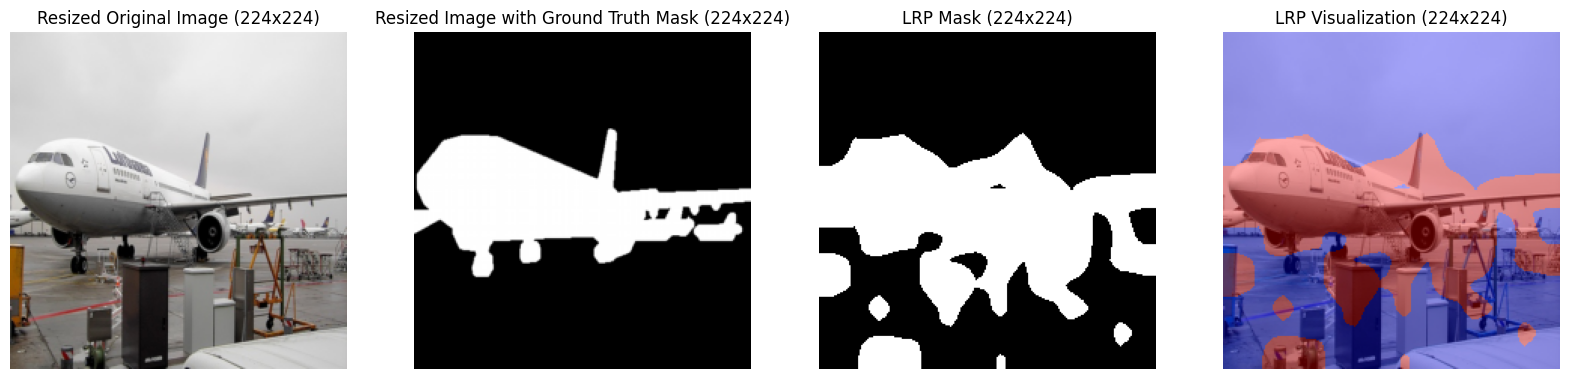

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T


# Load PASCAL VOC 2012 dataset
# dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=T.ToTensor())

# Helper function to overlay mask on image

# Select a sample from the dataset
image, true_mask = dataset[0]

# Convert tensor image to numpy array
image_np = image.permute(1, 2, 0).numpy()
image_np = (image_np * 255).astype(np.uint8)

# Convert mask to numpy array and resize to match the image dimensions
true_mask_np = np.array(true_mask)
true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# Overlay the mask on the original image
overlayed_image = overlay_mask(image_np, true_mask_np_resized)

# Convert images back to tensors
image_tensor = transforms.ToTensor()(image_np)
overlayed_image_tensor = transforms.ToTensor()(overlayed_image)

# Resize the original image and the overlayed image to 224x224
transform_resize = transforms.Compose([
    transforms.Resize((224, 224)),
])

image_resized = transform_resize(image_tensor)
overlayed_image_resized = transform_resize(overlayed_image_tensor)

# Convert tensor images to numpy arrays
image_np_resized = image_resized.permute(1, 2, 0).numpy()
image_np_resized = (image_np_resized * 255).astype(np.uint8)

overlayed_image_np_resized = overlayed_image_resized.permute(1, 2, 0).numpy()
overlayed_image_np_resized = (overlayed_image_np_resized * 255).astype(np.uint8)


# Generate LRP visualization
lrp_vis, lrp_mask = generate_visualization_LRP(image_resized, use_thresholding=True)

# Display the result
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Resized Original Image (224x224)")
plt.imshow(image_np_resized)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Resized Image with Ground Truth Mask (224x224)")
plt.imshow(overlayed_image_np_resized)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("LRP Mask (224x224)")
plt.imshow(lrp_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("LRP Visualization (224x224)")
plt.imshow(lrp_vis)
plt.axis('off')

plt.show()


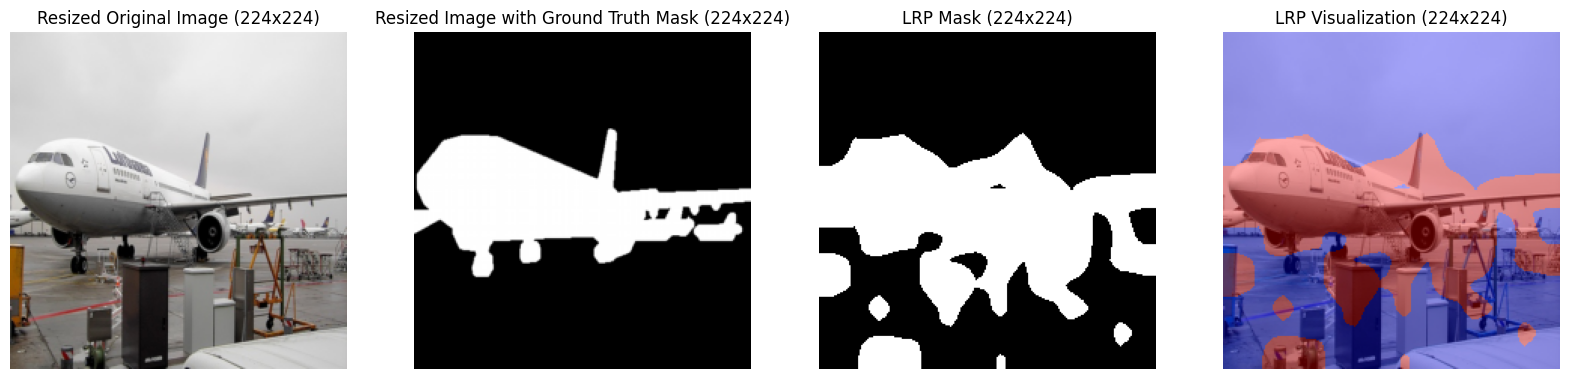

Jaccard Index: 0.5258313381218409
F1 Score: 0.6892391380152033
Pixel Accuracy: 0.8223852040816326


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T



# Select a sample from the dataset
image, true_mask = dataset[0]

# Convert tensor image to numpy array
image_np = image.permute(1, 2, 0).numpy()
image_np = (image_np * 255).astype(np.uint8)

# Convert mask to numpy array and resize to match the image dimensions
true_mask_np = np.array(true_mask)
true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# Binarize the true mask (foreground is 1, background is 0)
true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

# Overlay the mask on the original image
overlayed_image = overlay_mask(image_np, true_mask_np_resized)

# Convert images back to tensors
image_tensor = transforms.ToTensor()(image_np)
overlayed_image_tensor = transforms.ToTensor()(overlayed_image)

# Resize the original image and the overlayed image to 224x224
transform_resize = transforms.Compose([
    transforms.Resize((224, 224)),
])

image_resized = transform_resize(image_tensor)
overlayed_image_resized = transform_resize(overlayed_image_tensor)

# Convert tensor images to numpy arrays
image_np_resized = image_resized.permute(1, 2, 0).numpy()
image_np_resized = (image_np_resized * 255).astype(np.uint8)

overlayed_image_np_resized = overlayed_image_resized.permute(1, 2, 0).numpy()
overlayed_image_np_resized = (overlayed_image_np_resized * 255).astype(np.uint8)

# Initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

# Generate LRP visualization
lrp_vis, lrp_mask = generate_visualization_LRP(image_resized, use_thresholding=True)

# Compute metrics
predicted_mask_np = (lrp_mask > 0.5).astype(np.uint8)  # Binary mask from LRP visualization
true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

# Normalize binary masks to 0 and 1
true_mask_normalized = true_mask_resized.astype(np.uint8)
predicted_mask_normalized = predicted_mask_np.astype(np.uint8)

# Flatten the masks for metric calculation
true_mask_flat = true_mask_normalized.flatten()
predicted_mask_flat = predicted_mask_normalized.flatten()

# Jaccard Index and F1 Score
jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
f1 = f1_score(true_mask_flat, predicted_mask_flat)

# Pixel Accuracy
pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

# Display the result
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Resized Original Image (224x224)")
plt.imshow(image_np_resized)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Resized Image with Ground Truth Mask (224x224)")
plt.imshow(overlayed_image_np_resized)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("LRP Mask (224x224)")
plt.imshow(lrp_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("LRP Visualization (224x224)")
plt.imshow(lrp_vis)
plt.axis('off')

plt.show()

print(f"Jaccard Index: {jaccard}")
print(f"F1 Score: {f1}")
print(f"Pixel Accuracy: {pixel_accuracy}")

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP, Baselines
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T


def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Define methods for visualization
methods = {
    "LRP": generate_visualization_LRP,
    "Saliency": generate_saliency_visualization,
    "Rollout": visualize_rollout_heatmap,
    "CAM": visualize_CAM
}

# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
        for method_name, method in methods.items():
            # Generate visualization
            vis, vis_mask = method(image_resized, use_thresholding=True)

            # Compute metrics
            predicted_mask_np = (vis_mask > 0.5).astype(np.uint8)
            true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

            # Flatten the masks for metric calculation
            true_mask_flat = true_mask_resized.flatten()
            predicted_mask_flat = predicted_mask_np.flatten()

            # Jaccard Index and F1 Score
            jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
            f1 = f1_score(true_mask_flat, predicted_mask_flat)

            # Pixel Accuracy
            pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

            # Store metrics
            all_results.append({
                "Image Index": idx,
                "Method": method_name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics.csv", index=False)

print("Metrics have been saved to segmentation_metrics.csv")


Processing:   4%|▍         | 63/1449 [00:24<05:17,  4.37image/s]<ipython-input-15-cad58d6f70bf>:135: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  41%|████      | 587/1449 [02:01<01:31,  9.38image/s]<ipython-input-15-cad58d6f70bf>:135: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  85%|████████▌ | 1237/1449 [03:57<00:34,  6.11image/s]<ipython-input-15-cad58d6f70bf>:135: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  92%|█████████▏| 1328/1449 [04:11<00:18,  6.70image/s]<ipython-input-15-cad58d6f70bf>:135: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing: 100%|██████████| 1449/1449 [04:30<00:00,  5.35image/s]


Metrics have been saved to segmentation_metrics.csv


In [ ]:
import pandas as pd

# Load the CSV file
results_df = pd.read_csv("segmentation_metrics.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics_85.csv", index=False)

# Print the average metrics
print(average_metrics)


     Method  Image Index  Jaccard Index (IoU)  F1 Score  Pixel Accuracy
0       CAM   722.642651             0.124291  0.191258        0.659441
1       LRP   722.642651             0.364114  0.501885        0.755245
2   Rollout   722.642651             0.465134  0.611787        0.748097
3  Saliency   722.642651             0.091837  0.156331        0.662479


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP, Baselines
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from itertools import combinations


# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=1):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, method1, method2, combine_method, use_thresholding)

# Function to visualize all 2-way combinations
def visualize_all_combinations(input_image, combine_method='sqrt', use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))

    results = []
    for combo in combinations_list:
        #print(f"Visualizing {' + '.join(combo)}")
        vis, combined_attr = visualize_combined_methods(input_image, combo[0], combo[1], combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis, combined_attr))

    return results
def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()
# Define methods for visualization
methods = {
    "LRP": generate_visualization_LRP,
    "Saliency": generate_saliency_visualization,
    "Rollout": visualize_rollout_heatmap,
    "CAM": visualize_CAM
}

# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
        # Visualize all combinations
        results = visualize_all_combinations(image_resized, combine_method='sqrt', use_thresholding=True)

        for name, vis, combined_attr in results:
            # Compute metrics
            predicted_mask_np = (combined_attr > 0.5).astype(np.uint8)
            true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

            # Flatten the masks for metric calculation
            true_mask_flat = true_mask_resized.flatten()
            predicted_mask_flat = predicted_mask_np.flatten()

            # Jaccard Index and F1 Score
            jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
            f1 = f1_score(true_mask_flat, predicted_mask_flat)

            # Pixel Accuracy
            pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

            # Store metrics
            all_results.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

            # Save the results
            #save_path = os.path.join(folder2, f"{name.replace(' + ', '_')}.png")
            #cv2.imwrite(save_path, cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics_combined2_sqrt.csv", index=False)

print("Metrics have been saved.csv")

# Display the results
# fig, axes = plt.subplots(len(results)//2 + len(results) % 2, 2, figsize=(15, len(results)*2))
# for ax, (name, result) in zip(axes.flatten(), results):
#     ax.imshow(result)
#     ax.set_title(name)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

# Load the CSV file
#results_df = pd.read_csv("segmentation_metrics_combined2_rollout1.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics2.csv", index=False)

# Print the average metrics
print(average_metrics)


Processing:   4%|▍         | 62/1449 [00:23<07:24,  3.12image/s]<ipython-input-8-8f678b72e7ab>:58: RuntimeWarning: invalid value encountered in cast
  combined_attr = combined_attr.astype(np.uint8)
Processing:  41%|████      | 587/1449 [03:09<02:56,  4.87image/s]<ipython-input-8-8f678b72e7ab>:58: RuntimeWarning: invalid value encountered in cast
  combined_attr = combined_attr.astype(np.uint8)
Processing:  51%|█████     | 734/1449 [04:05<03:59,  2.98image/s]


KeyboardInterrupt: 

In [ ]:
###########
###########
###########
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP, Baselines
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from itertools import combinations


# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=1):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='weighted', weight1=0.5, use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2
    elif combine_method == 'weighted':
        combined_attr = weight1 * attr1 + (1 - weight1) * attr2

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, combine_method='weighted', weight1=0.5, use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, method1, method2, combine_method, weight1, use_thresholding)

# Function to visualize all 2-way combinations with varying weights
def visualize_all_combinations_with_weights(input_image, use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 2))
    weights = [i / 100.0 for i in range(10, 100, 20)]

    results = []
    for combo in combinations_list:
        for weight in weights:
            vis, combined_attr = visualize_combined_methods(input_image, combo[0], combo[1], combine_method='weighted', weight1=weight, use_thresholding=use_thresholding)
            results.append((f"{combo[0]} ({int(weight*100)}%) + {combo[1]} ({int((1-weight)*100)}%)", vis, combined_attr))

    return results

def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
        # Visualize all combinations with weights
        results = visualize_all_combinations_with_weights(image_resized, use_thresholding=True)

        for name, vis, combined_attr in results:
            # Compute metrics
            predicted_mask_np = (combined_attr > 0.5).astype(np.uint8)
            true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

            # Flatten the masks for metric calculation
            true_mask_flat = true_mask_resized.flatten()
            predicted_mask_flat = predicted_mask_np.flatten()

            # Jaccard Index and F1 Score
            jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
            f1 = f1_score(true_mask_flat, predicted_mask_flat)

            # Pixel Accuracy
            pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

            # Store metrics
            all_results.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics_combined_with_weights.csv", index=False)

print("Metrics have been saved.csv")

# Load the CSV file
# results_df = pd.read_csv("segmentation_metrics_combined_with_weights.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics_with_weights.csv", index=False)

# Print the average metrics
print(average_metrics)
#######################
#######################
#######################

Processing:   0%|          | 6/1449 [00:07<30:46,  1.28s/image]  


KeyboardInterrupt: 

Processing:   0%|          | 0/1449 [00:00<?, ?image/s]

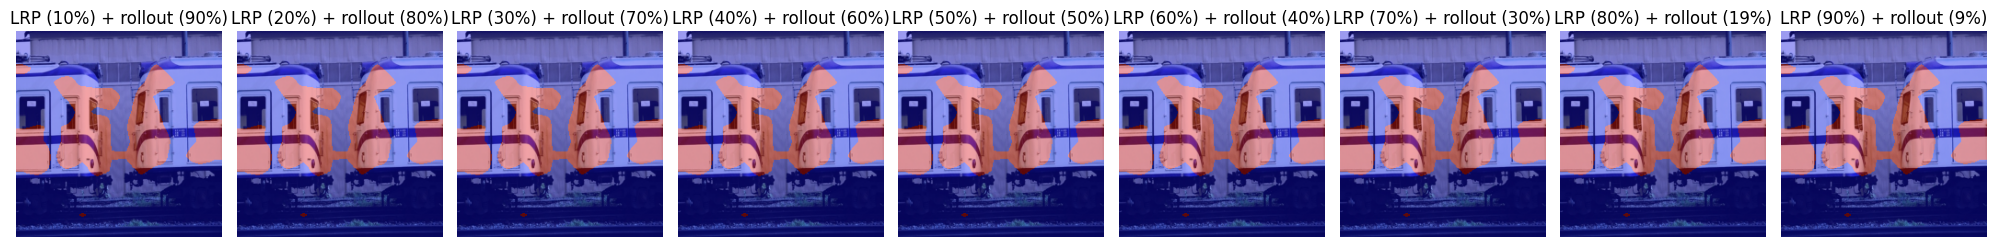

Processing:   0%|          | 1/1449 [00:03<1:21:40,  3.38s/image]


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import pandas as pd
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP, Baselines
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from itertools import combinations

# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=1):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, method1, method2, combine_method='weighted', weight1=0.5, use_thresholding=True):
    device = input_image.device
    attr1 = method1(input_image).reshape(1, 1, 14, 14).to(device)
    attr2 = method2(input_image).reshape(1, 1, 14, 14).to(device)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attr1 * attr2)
    elif combine_method == 'multiply':
        combined_attr = attr1 * attr2
    elif combine_method == 'weighted':
        combined_attr = (weight1 * attr1) *( (1 - weight1) * attr2)

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method1_name, method2_name, combine_method='weighted', weight1=0.5, use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        #'saliency': generate_saliency,
        'rollout': generate_rollout,
        # 'CAM': generate_CAM,
    }
    method1 = methods[method1_name]
    method2 = methods[method2_name]

    return combine_and_visualize_attributions(input_image, method1, method2, combine_method, weight1, use_thresholding)

# Function to visualize all 2-way combinations with varying weights
def visualize_all_combinations_with_weights(input_image, use_thresholding=True):
    methods = ['LRP', 'rollout']
    combinations_list = list(combinations(methods, 2))
    weights = [i / 100.0 for i in range(10, 100, 10)]

    results = []
    for combo in combinations_list:
        for weight in weights:
            vis, combined_attr = visualize_combined_methods(input_image, combo[0], combo[1], combine_method='weighted', weight1=weight, use_thresholding=use_thresholding)
            results.append((f"{combo[0]} ({int(weight*100)}%) + {combo[1]} ({int((1-weight)*100)}%)", vis, combined_attr))

    return results

def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Load the dataset
#dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=transforms.ToTensor())



# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 85%
    if top_prob > 0.98:
        # Visualize all combinations with weights
        results = visualize_all_combinations_with_weights(image_resized, use_thresholding=True)

        # Plot and display the results for each combination
        fig, axes = plt.subplots(1, len(results), figsize=(20, 5))
        for ax, (name, vis, _) in zip(axes, results):
            ax.set_title(name)
            ax.imshow(vis)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        # Only process the first image that meets the criteria
        break


In [ ]:
import pandas as pd

# Load the CSV file
results_df = pd.read_csv("segmentation_metrics_combined2.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics2.csv", index=False)

# Print the average metrics
print(average_metrics)


               Method  Image Index  Jaccard Index (IoU)  F1 Score  \
0           LRP + CAM   745.185662             0.231560  0.338445   
1       LRP + rollout   745.185662             0.477096  0.614204   
2      LRP + saliency   745.185662             0.352912  0.489947   
3       rollout + CAM   745.185662             0.218429  0.313933   
4      saliency + CAM   745.185662             0.177278  0.260435   
5  saliency + rollout   745.185662             0.283573  0.410276   

   Pixel Accuracy  
0        0.706929  
1        0.790710  
2        0.736683  
3        0.682204  
4        0.672403  
5        0.665633  


In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP, Baselines
from torchvision.datasets import VOCSegmentation
from itertools import combinations



# Define the attribution functions
def generate_LRP(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    return transformer_attribution

def generate_saliency(original_image, class_index=None):
    original_image.requires_grad_()
    output = model(original_image.unsqueeze(0).cuda())
    loss = output[0, class_index] if class_index is not None else output.max()
    model.zero_grad()
    loss.backward()
    saliency = original_image.grad.data.abs().max(dim=0, keepdim=True)[0]
    saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0), size=(14, 14), mode='bilinear')
    return saliency

def generate_rollout(input_image, start_layer=3):
    transformer_attribution = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=start_layer)
    return transformer_attribution

def generate_CAM(input_image, class_index=None):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    return transformer_attribution

# Utility function to combine attributions and visualize
def combine_and_visualize_attributions(input_image, methods, combine_method='sqrt', use_thresholding=True):
    device = input_image.device
    attributions = []
    for method in methods:
        if method.__name__ in ['generate_saliency', 'generate_CAM']:
            attr = method(input_image, class_index=1).reshape(1, 1, 14, 14).to(device)  # class_index is set to 1 for demonstration
        else:
            attr = method(input_image).reshape(1, 1, 14, 14).to(device)
        attributions.append(attr)

    if combine_method == 'sqrt':
        combined_attr = torch.sqrt(attributions[0] * attributions[1] * attributions[2])
    elif combine_method == 'multiply':
        combined_attr = attributions[0] * attributions[1] * attributions[2]

    combined_attr = torch.nn.functional.interpolate(combined_attr, scale_factor=16, mode='bilinear')
    combined_attr = combined_attr.reshape(224, 224).cpu().detach().numpy()
    combined_attr = (combined_attr - combined_attr.min()) / (combined_attr.max() - combined_attr.min())

    if use_thresholding:
        combined_attr = combined_attr * 255
        combined_attr = combined_attr.astype(np.uint8)
        _, combined_attr = cv2.threshold(combined_attr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        combined_attr[combined_attr == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).cpu().detach().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, combined_attr)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, combined_attr

# Example usage
def visualize_combined_methods(input_image, method_names, combine_method='sqrt', use_thresholding=True):
    methods = {
        'LRP': generate_LRP,
        'saliency': generate_saliency,
        'rollout': generate_rollout,
        'CAM': generate_CAM,
    }
    selected_methods = [methods[name] for name in method_names]

    return combine_and_visualize_attributions(input_image, selected_methods, combine_method, use_thresholding)

# Function to visualize all 3-way combinations
def visualize_all_3way_combinations(input_image, combine_method='sqrt', use_thresholding=True):
    methods = ['LRP', 'saliency', 'rollout', 'CAM']
    combinations_list = list(combinations(methods, 3))

    results = []
    for combo in combinations_list:
        #print(f"Visualizing {' + '.join(combo)}")
        vis, combined_attr = visualize_combined_methods(input_image, combo, combine_method, use_thresholding)
        results.append((f"{' + '.join(combo)}", vis, combined_attr))

    return results


# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
        # Visualize all 3-way combinations
        results = visualize_all_3way_combinations(image_resized, combine_method='sqrt', use_thresholding=True)

        for name, vis, combined_attr in results:
            # Compute metrics
            predicted_mask_np = (combined_attr > 0.5).astype(np.uint8)
            true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

            # Flatten the masks for metric calculation
            true_mask_flat = true_mask_resized.flatten()
            predicted_mask_flat = predicted_mask_np.flatten()

            # Jaccard Index and F1 Score
            jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
            f1 = f1_score(true_mask_flat, predicted_mask_flat)

            # Pixel Accuracy
            pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

            # Store metrics
            all_results.append({
                "Image Index": idx,
                "Method": name,
                "Jaccard Index (IoU)": jaccard,
                "F1 Score": f1,
                "Pixel Accuracy": pixel_accuracy
            })


# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics_combined_3way_85.csv", index=False)

print("Metrics have been saved to segmentation_metrics_combined_3way.csv")

average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics3_85.csv", index=False)

# Print the average metrics
print(average_metrics)



Processing:  31%|███       | 450/1449 [02:32<05:33,  3.00image/s]<ipython-input-21-0a293556e0b4>:63: RuntimeWarning: invalid value encountered in cast
  combined_attr = combined_attr.astype(np.uint8)
Processing: 100%|██████████| 1449/1449 [08:26<00:00,  2.86image/s]


Metrics have been saved to segmentation_metrics_combined_3way.csv
                     Method  Image Index  Jaccard Index (IoU)  F1 Score  \
0       LRP + rollout + CAM   722.642651             0.329571  0.459829   
1      LRP + saliency + CAM   722.642651             0.259725  0.379138   
2  LRP + saliency + rollout   722.642651             0.389262  0.527585   
3  saliency + rollout + CAM   722.642651             0.218389  0.318725   

   Pixel Accuracy  
0        0.735078  
1        0.709650  
2        0.750383  
3        0.681908  


# Not used

In [ ]:
# fig, axs = plt.subplots(1, 3)
# axs[0].imshow(image);
# axs[0].axis('off');
# # cat - the predicted class
# cat = generate_visualization_CAMrollout(dog_cat_image)
# # dog
# # generate visualization for class 243: 'bull mastiff'
# dog = generate_visualization_CAMrollout(dog_cat_image, class_index=243)

# axs[1].imshow(cat);
# axs[1].axis('off');
# axs[2].imshow(dog);
# axs[2].axis('off');

In [ ]:
# #@title Perform thresholding on the relevance (using Otsu's method)
# prev_use_thresholding = use_thresholding
# if not use_thresholding:
#   use_thresholding = True
# # image = Image.open('samples/catdog.png')
# dog_cat_image = transform(image)

# fig, axs = plt.subplots(1, 3)
# axs[0].imshow(image);
# axs[0].axis('off');

# output = model(dog_cat_image.unsqueeze(0).cuda())
# print_top_classes(output)

# # cat - the predicted class
# cat = generate_visualization(dog_cat_image)

# # dog
# # generate visualization for class 243: 'bull mastiff'
# dog = generate_visualization(dog_cat_image, class_index=243)

# if not prev_use_thresholding:
#   use_thresholding = False

# axs[1].imshow(cat);
# axs[1].axis('off');
# axs[2].imshow(dog);
# axs[2].axis('off');

In [ ]:

# """# LRP + rollout

# torch.sqrt(r * a) could help for object segmentation
# """

# def generate_visualization_LRProllout(input_image, class_index=None):
#   r = b.generate_rollout(input_image.unsqueeze(0).cuda(), start_layer=1).reshape(1, 1, 14, 14)
#   a = attribution_generator.generate_LRP(input_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach().reshape(1, 1, 14, 14)
#   # transformer_attribution = (r+a)/2
# #   alpha = 0.8  # Weight for saliency
# #   beta = 1 - alpha  # Weight for LRP
# #   transformer_attribution = (alpha * a + beta * r)
#   transformer_attribution = torch.sqrt(a*r)
#   transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
#   transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
#   transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
#   image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
#   image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
#   vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
#   vis =  np.uint8(255 * vis)
#   vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
#   return vis


# """# CAM+rollout"""

# def generate_visualization_CAMrollout(input_image, class_index=None):
#   r = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
#   a = attribution_generator.generate_LRP(input_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach().reshape(1, 1, 14, 14)
#   # transformer_attribution = (r+a)/2
#   # alpha = 0.2  # Weight for saliency
#   # beta = 1 - alpha  # Weight for LRP
#   # transformer_attribution = (alpha * a + beta * r)
#   transformer_attribution = a*r
#   transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
#   transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
#   transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
#   image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
#   image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
#   vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
#   vis =  np.uint8(255 * vis)
#   vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
#   return vis

# """# LRP + saliency

# torch.sqrt also toward segmentation
# """

# def generate_vizualition_LRPsaliency(input_image, class_index=None):
#     # Generate LRP attribution
#     lrp = attribution_generator.generate_LRP(dog_cat_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach().reshape(1, 1, 14, 14)

#     # Compute saliency map
#     dog_cat_image.requires_grad_()
#     output = model(dog_cat_image.unsqueeze(0).cuda())
#     loss = output[0, class_index] if class_index is not None else output.max()  # defines the loss that we want to compute gradients for
#     model.zero_grad()
#     loss.backward()  # computes the gradient of the loss with respect to the original_image

#     # Compute the absolute value of the gradients and take the maximum value across the color channels
#     saliency = dog_cat_image.grad.data.abs().max(dim=1, keepdim=True)[0].view(3, 224)
#     # Interpolate the saliency map to the size of 14x14 and average along the dimension
#     saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0).unsqueeze(0), size=(14, 14), mode='bilinear', align_corners=False).mean(dim=2)

#     # Ensure saliency is on the same device as lrp
#     saliency = saliency.to(lrp.device)

#     # Combine LRP with saliency
#     transformer_attribution = torch.sqrt(lrp*saliency)
#     transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
#     transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
#     transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
#     image_transformer_attribution = dog_cat_image.permute(1, 2, 0).data.cpu().numpy()
#     image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
#     vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
#     vis = np.uint8(255 * vis)
#     vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
#     return vis

# """# CAM+saliency"""

# def generate_vizualition_CAMsaliency(input_image, class_index=None):
#     # Generate LRP attribution
#     lrp = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index).detach().reshape(1, 1, 14, 14)

#     # Compute saliency map
#     dog_cat_image.requires_grad_()
#     output = model(dog_cat_image.unsqueeze(0).cuda())
#     loss = output[0, class_index] if class_index is not None else output.max()  # defines the loss that we want to compute gradients for
#     model.zero_grad()
#     loss.backward()  # computes the gradient of the loss with respect to the original_image

#     # Compute the absolute value of the gradients and take the maximum value across the color channels
#     saliency = dog_cat_image.grad.data.abs().max(dim=1, keepdim=True)[0].view(3, 224)
#     # Interpolate the saliency map to the size of 14x14 and average along the dimension
#     saliency = torch.nn.functional.interpolate(saliency.unsqueeze(0).unsqueeze(0), size=(14, 14), mode='bilinear', align_corners=False).mean(dim=2)

#     # Ensure saliency is on the same device as lrp
#     saliency = saliency.to(lrp.device)

#     # Combine LRP with saliency
#     # transformer_attribution = (lrp + saliency) / 2
#     transformer_attribution = lrp*saliency
#     transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
#     transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
#     transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
#     image_transformer_attribution = dog_cat_image.permute(1, 2, 0).data.cpu().numpy()
#     image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
#     vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
#     vis = np.uint8(255 * vis)
#     vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
#     return vis